# Assignment 3

###### Created by Qihang Ma -- 2023.02.13

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t
from statsmodels.tsa.arima.model import ARIMA
from scipy.optimize import minimize 

## Problem 1 - Price Return Calculation

Calculate and compare the expected value and standard deviation of price at time t (P𝑡) ,given each of the 3 types of price returns, assuming 𝑟𝑡 ∼ 𝑁(0, σ2). 

Simulate each return equation using 𝑟𝑡 ∼ 𝑁(0, σ2)and show the mean and standard deviation match your expectations.

In [2]:
def simulate_classical_brownian_motion(P0, N, sigma, mu):
    rt = np.random.normal(mu, sigma, N)
    P = np.zeros(N)
    for i in range(N):
        P[i] = P0 + rt[i]
    return P

In [3]:
def simulate_arithmetic_return_system(P0, N, sigma, mu):
    rt = np.random.normal(mu, sigma, N)
    P = np.zeros(N)
    for i in range(N):
        P[i] = P0 * (1 + rt[i])
    return P

In [4]:
def simulate_log_return(P0, N, sigma, mu):
    rt = np.random.normal(mu, sigma, N)
    P = np.zeros(N)
    for i in range(N):
        P[i] = P0 * np.exp(rt[i])
    return P

In [5]:
def simulate_price(method, P0, N, sigma, mu):
    np.random.seed(123)
    
    if method == "classical":
        return_method = "Classical Brownian Motion"
        S = simulate_classical_brownian_motion(P0, N, sigma, mu)
        theoretically_value = P0
        theoretically_std = sigma
    elif method == "arithmetic":
        return_method = "Arithmetic_return_system"
        S = simulate_arithmetic_return_system(P0, N, sigma, mu)
        theoretically_value = P0
        theoretically_std = sigma * P0
    elif method == "log":
        return_method = "Geometric Brownian Motion"
        S = simulate_log_return(P0, N, sigma, mu)
        theoretically_value = P0 * np.exp(mu+0.5*sigma**2)
        theoretically_std = np.sqrt((np.exp(sigma**2)-1)*np.exp(2*(mu+ np.log(P0))+sigma**2))
    else:
        raise ValueError("Invalid method. Choose from classical_brownian_motion, arithmetic_return_system, or log_return.")

    print("Type: {}".format(return_method))
    print("Expected Value: ", np.mean(S))
    print("Standard Deviation: ", np.std(S))
    print("Theoretically Expected Value: ", theoretically_value)
    print("Theoretically Standard Deviation: ", theoretically_std)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(S, bins=50, density=True, alpha=0.5)
    ax.set_title("Frequency Distribution Histogram")
    sns.kdeplot(S, ax=ax, label='Kernel Density Estimation')
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')
    plt.savefig("Return_{}".format(return_method), dpi =300)
    plt.show()

Type: Classical Brownian Motion
Expected Value:  100.00145678384374
Standard Deviation:  0.14971707818852212
Theoretically Expected Value:  100
Theoretically Standard Deviation:  0.15


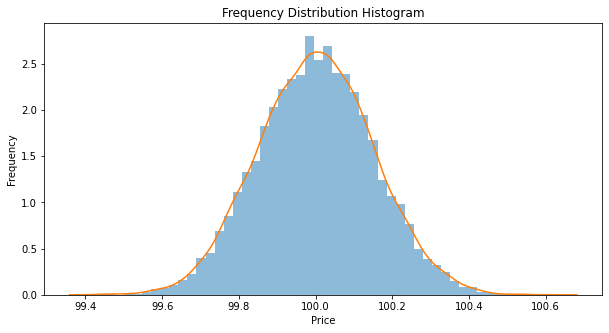

Type: Arithmetic_return_system
Expected Value:  100.14567838437394
Standard Deviation:  14.971707818852211
Theoretically Expected Value:  100
Theoretically Standard Deviation:  15.0


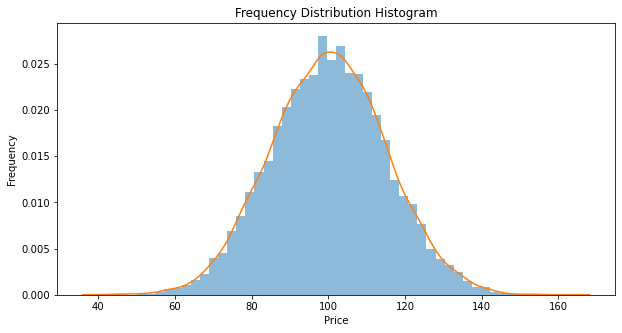

Type: Geometric Brownian Motion
Expected Value:  101.27468382900759
Standard Deviation:  15.249994627339916
Theoretically Expected Value:  101.13135192236113
Theoretically Standard Deviation:  15.255433702216127


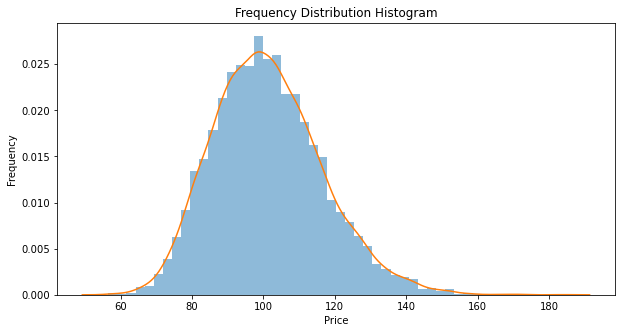

In [6]:
P0 = 100
N = 10000
sigma = 0.15
mu = 0
methods = ["classical", "arithmetic", "log"]
for method in methods:
    simulate_price(method, P0, N, sigma, mu)

## Problem 2 - VaR Calculation

Implement a function similar to the “return_calculate()” in this week’s code. Allow the user to specify the method of return calculation.

Use DailyPrices.csv. Calculate the arithmetic returns for all prices.

Remove the mean from the series so that the mean(META)=0

Calculate VaR
1. Using a normal distribution.
2. Using a normal distribution with an Exponentially Weighted variance (λ = 0. 94)
3. Using a MLE fitted T distribution.
4. Using a fitted AR(1) model.
5. Using a Historic Simulation.

Compare the 5 values.

####  Implement return_calculate()

In [7]:
def return_calculate(prices, method="DISCRETE", dateColumn="Date"):
    vars_ = prices.columns
    nVars = len(vars_)
    vars_ = [var for var in vars_ if var != dateColumn]
    if nVars == len(vars_):
        raise ValueError(f"dateColumn: {dateColumn} not in DataFrame: {vars_}")
    nVars = nVars - 1

    p = prices[vars_].to_numpy()
    n, m = p.shape
    p2 = np.empty((n-1, m))

    for i in range(n-1):
        for j in range(m):
            p2[i, j] = p[i+1, j] / p[i, j]

    if method.upper() == "DISCRETE":
        p2 = p2 - 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError(f"method: {method} must be in (\"LOG\",\"DISCRETE\")")

    dates = prices[dateColumn].iloc[1:n].to_numpy()
    out = pd.DataFrame({dateColumn: dates})
    for i in range(nVars):
        out[vars_[i]] = p2[:, i]

    return out

In [8]:
prices = pd.read_csv('DailyPrices.csv')
returns_all = return_calculate(prices)

### Calculate the VaR for META

In [9]:
meta = returns_all['META']-returns_all['META'].mean()

#### 1. Using a normal distribution

In [10]:
def calculate_var_normal(returns, num_simulations=10000, alpha=0.05):
    """Calculate VaR using a normal distribution"""
    mu = returns.mean()
    sigma = returns.std()
    sim_returns = np.random.normal(mu, sigma, num_simulations)
    sim_returns.sort()
    var_normal = -sim_returns[int(alpha * len(sim_returns))]
    return var_normal, sim_returns

#### 2.  Using a normal distribution with an Exponentially Weighted variance (λ = 0. 94)

In [11]:
def exp_weighted_cov(returns, lambda_=0.97):
    """
    Perform calculation on the input data set with a given λ for exponentially weighted covariance.
    
    Parameters:
    - data: input data set, a pandas DataFrame
    - lambda_: fraction for unpdate the covariance matrix, default 0.97
    
    Returns:
    cov: an exponentially weighted covariance matrix, a numpy array
    """
    
    # Preprocess the data
    returns = returns.values
    mean_return = np.mean(returns, axis=0)
    normalized_returns = returns - mean_return
    
    # Initializing the covariance matrix
    n_timesteps = normalized_returns.shape[0]
    cov = np.cov(returns, rowvar=False)
    
    # Updating the covariance matrix
    for t in range(1, n_timesteps):
        cov = lambda_ * cov + (1 - lambda_) * np.outer(normalized_returns[t], normalized_returns[t])
    return cov

In [12]:
def calculate_var_ew_normal(returns, lambda_=0.94, num_simulations=10000, alpha=0.05):
    """Calculate VaR using a normal distribution with exponentially weighted variance"""
    mu = returns.mean()
    sigma = np.sqrt(exp_weighted_cov(returns, lambda_=lambda_))
    sim_returns = np.random.normal(mu, sigma[0][0], num_simulations)
    var_ew = -np.percentile(sim_returns, alpha*100)
    return var_ew, sim_returns

#### 3. Using a MLE fitted T distribution

In [13]:
def MLE_T(params, returns):
    negLL = -1 * np.sum(t.logpdf(returns, df=params[0], loc=params[1], scale=params[2]))
    return(negLL)

In [14]:
def calculate_var_t_MLE(returns, num_simulations=10000, alpha=0.05):
    """Calculate VaR using a T-distribution with MLE fitted degrees of freedom"""
    constraints=({"type":"ineq", "fun":lambda x: x[0]-1}, {"type":"ineq", "fun":lambda x: x[2]})
    returns_t = minimize(MLE_T, x0=[10, np.mean(returns), np.std(returns)], args=returns, constraints=constraints)
    df, loc, scale = returns_t.x[0], returns_t.x[1], returns_t.x[2]
    sim_returns = t.rvs(df, loc=loc, scale=scale, size=num_simulations)
    var_t = -np.percentile(sim_returns, alpha*100)
    return var_t, sim_returns

#### 4. Using a fitted AR(1) model

In [15]:
def calculate_var_ar1(returns, num_simulations=10000, alpha=0.05):
    """Calculate VaR using an AR(1) model"""
    model = ARIMA(returns, order=(1, 0, 0)).fit()
    alpha_1 = model.params[0]
    beta = model.params[1]
    resid = model.resid
    sigma = np.std(resid)
    sim_returns = np.empty(num_simulations)
    returns = returns.values
    for i in range(num_simulations):
        sim_returns[i] =  alpha_1 * (returns[-1]) + sigma * np.random.normal()
    var_ar1 = -np.percentile(sim_returns, alpha*100)
    return var_ar1, sim_returns

#### 5. Using a Historic Simulation

In [16]:
def calculate_var_hist(returns, alpha=0.05):
    """Calculate VaR using historic simulation"""
    var_hist = -np.percentile(returns, alpha*100)
    return var_hist, returns

#### Calculate the VaR and Compare

In [17]:
def plot_histogram_with_var(series, var, title):
    """Plot the distribution for the series with the VaR marked on the figure"""
    plt.hist(series, bins=80, density=True, alpha=0.5)
    sns.kdeplot(series, color='g', linewidth=1)
    plt.axvline(-var, color='r', linestyle='--')
    plt.title(title + ' = {:.6f}'.format(var))
    plt.savefig(title, dpi =300)
    plt.show()

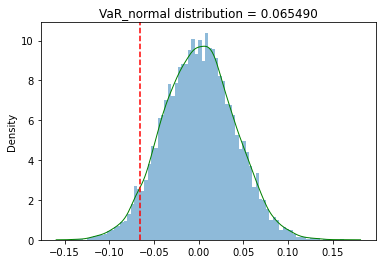

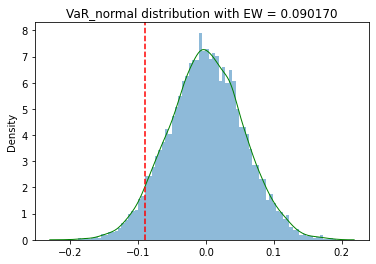

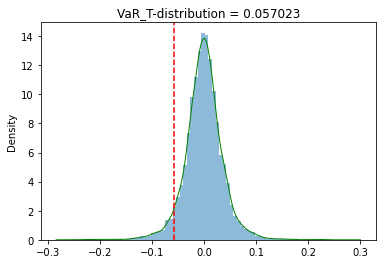

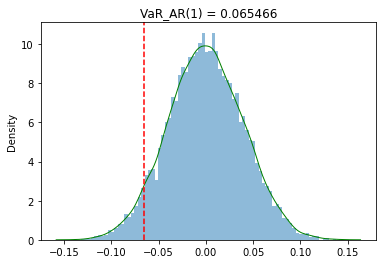

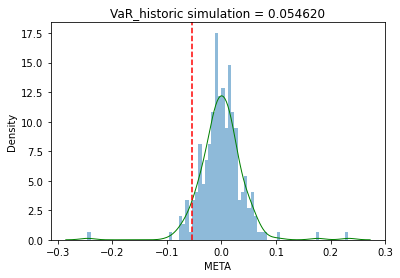

In [18]:
var_normal, returns_normal = calculate_var_normal(meta)
plot_histogram_with_var(returns_normal, var_normal, "VaR_normal distribution")

var_ew, returns_ew = calculate_var_ew_normal(meta)
plot_histogram_with_var(returns_ew, var_ew, "VaR_normal distribution with EW")

var_t, returns_t = calculate_var_t_MLE(meta)
plot_histogram_with_var(returns_t, var_t, "VaR_T-distribution")

var_ar1, returns_ar1 = calculate_var_ar1(meta)
plot_histogram_with_var(returns_ar1, var_ar1, "VaR_AR(1)")

var_hist, returns_hist = calculate_var_hist(meta)
plot_histogram_with_var(returns_hist, var_hist, "VaR_historic simulation")

In [19]:
print('Dollar Loss')
print('$VaR (normal distribution) = {:.4f}' .format((var_normal-returns_all['META'].mean()) * prices['META'].values[-1]))
print('$VaR (normal distribution with EW) = {:.4f}' .format((var_ew-returns_all['META'].mean()) * prices['META'].values[-1]))
print('$VaR (T-distribution) = {:.4f}' .format((var_t-returns_all['META'].mean()) * prices['META'].values[-1]))
print('$VaR (AR(1)) = {:.4f}' .format((var_ar1-returns_all['META'].mean()) * prices['META'].values[-1]))
print('$VaR (historic simulation) = {:.4f}' .format((var_hist-returns_all['META'].mean()) * prices['META'].values[-1]))

Dollar Loss
$VaR (normal distribution) = 11.6549
$VaR (normal distribution with EW) = 16.0460
$VaR (T-distribution) = 10.1485
$VaR (AR(1)) = 11.6507
$VaR (historic simulation) = 9.7209


## Problem 3 - Portfolio VaR Calculation

Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0.

This file contains the stock holdings of 3 portfolios. You own each of these portfolios. Using an exponentially weighted covariance with lambda = 0.94, calculate the VaR of each portfolio as well as your total VaR (VaR of the total holdings). Express VaR as a $.

Discuss your methods and your results.

Choose a different model for returns and calculate VaR again. Why did you choose that model? How did the model change affect the results?

In [20]:
portfolio = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")

In [21]:
def get_portfolio_price(portfolio, prices, portfolio_code, Delta=False):
    """Get the price for each asset in portfolio and calculate the current price."""
    
    if portfolio_code == "All":
        assets = portfolio.drop('Portfolio',axis=1)
        assets = assets.groupby(["Stock"], as_index=False)["Holding"].sum()
    else:
        assets = portfolio[portfolio["Portfolio"] == portfolio_code]
        
    stock_codes = list(assets["Stock"])
    assets_prices = pd.concat([prices["Date"], prices[stock_codes]], axis=1)
    
    current_price = np.dot(prices[assets["Stock"]].tail(1), assets["Holding"])
    holdings = assets["Holding"]
    
    if Delta == True:
        asset_values = assets["Holding"].values.reshape(-1, 1) * prices[assets["Stock"]].tail(1).T.values
        delta = asset_values / current_price
        
        return current_price, assets_prices, delta
    
    return current_price, assets_prices, holdings


#### Calculate VaR with Delta Normal VaR method

In [22]:
def calculate_delta_var(portfolio, prices, alpha=0.05, lambda_=0.94, portfolio_code="All"):
    """
    Calculate delta VaR for a given portfolio using the Delta Normal VaR method.
    
    Parameters:
    - portfolio: a pandas DataFrame with columns 'Portfolio', 'Stock', and 'Holding'
    - prices: a pandas DataFrame with columns 'Date' and stock codes as column names
    - alpha: the significance level for VaR calculation, default 0.05
    - lambda_: fraction for update the covariance matrix, default 0.94
    - portfolio_code: a string for the specific portfolio to calculate, default "All"
    
    Returns:
    - current_value: current value for the specific portfolio
    - VaR: delta VaR for the portfolio in $
    """
    
    current_price, assets_prices, delta = get_portfolio_price(portfolio, prices, portfolio_code, Delta=True)

    returns = return_calculate(assets_prices).drop('Date', axis=1)
    assets_cov = exp_weighted_cov(returns, lambda_)

    p_sig = np.sqrt(np.transpose(delta) @ assets_cov @ delta)
    
    var_delta = -current_price * norm.ppf(alpha) * p_sig
    
    return current_price[0], var_delta[0][0]


#### Calculate VaR with Normal Monte Carlo simulation

In [23]:
def multivariate_normal_simulation(covariance_matrix, n_samples, explained_variance=1.0):

        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        # Only consider eigenvalues greater than 0
        idx = eigenvalues > 1e-8
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Sort the eigenvalues in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Update the explained_variance incase the explained_variance is higher than the cumulative sum of the eigenvalue
        if explained_variance == 1.0:
            explained_variance = (np.cumsum(eigenvalues)/np.sum(eigenvalues))[-1]
        
        # Determine the number of components to keep based on the explained variance ratio
        n_components = np.where((np.cumsum(eigenvalues)/np.sum(eigenvalues))>= explained_variance)[0][0] + 1
        eigenvectors = eigenvectors[:,:n_components]
        eigenvalues = eigenvalues[:n_components]

        normal_samples = np.random.normal(size=(n_components, n_samples))
        
        # Simulate the multivariate normal samples by multiplying the eigenvectors with the normal samples
        B = np.dot(eigenvectors, np.diag(np.sqrt(eigenvalues)))
        samples = np.transpose(np.dot(B, normal_samples))
        
        return samples

In [24]:
def calculate_MC_var(portfolio, prices, alpha=0.05, lambda_=0.94, n_simulation = 10000, portfolio_code="All"):
    """
    Calculate delta VaR for a given portfolio using the Delta Normal VaR method.
    
    Parameters:
    - portfolio: a pandas DataFrame with columns 'Portfolio', 'Stock', and 'Holding'
    - prices: a pandas DataFrame with columns 'Date' and stock codes as column names
    - alpha: the significance level for VaR calculation, default 0.05
    - lambda_: fraction for update the covariance matrix, default 0.94
    - portfolio_code: a string for the specific portfolio to calculate, default "All"
    
    Returns:
    - current_value: current value for the specific portfolio
    - VaR: delta VaR for the portfolio in $
    """
    
    current_price, assets_prices, holdings = get_portfolio_price(portfolio, prices, portfolio_code)
    
    returns = return_calculate(assets_prices).drop('Date',axis=1)
    returns_norm = returns - returns.mean()
    assets_cov = exp_weighted_cov(returns_norm, lambda_)
    
    assets_prices = assets_prices.drop('Date',axis=1)
    np.random.seed(0)
    sim_returns = np.add(multivariate_normal_simulation(assets_cov, n_simulation), returns.mean().values)
    sim_prices = np.dot(sim_returns* assets_prices.tail(1).values.reshape(assets_prices.shape[1],),holdings)
    
    var_MC = -np.percentile(sim_prices, alpha*100)
    
    return current_price[0], var_MC, sim_prices
    

#### Calculate VaR with Historical VaR

In [25]:
def calculate_historic_var(portfolio, prices, alpha=0.05,n_simulation=1000, portfolio_code="All"):
    """
    Calculate historical Value at Risk (VaR) for a given portfolio using exponentially weighted covariance.

    Parameters:
    - portfolio: a pandas DataFrame of the portfolio with columns "Portfolio", "Stock", "Holding"
    - prices: a pandas DataFrame of historical prices with columns "Date" and stock codes as other columns
    - alpha: a float between 0 and 1 for the confidence level, default 0.05
    - portfolio_code: a string for the specific portfolio to calculate, default "All"

    Returns:
    - historic_var: a float for the historical VaR in $
    """
    
    current_price, assets_prices, holdings = get_portfolio_price(portfolio, prices, portfolio_code)
    
    returns = return_calculate(assets_prices).drop("Date", axis=1)
    
    assets_prices = assets_prices.drop('Date',axis=1)
    sim_returns = returns.sample(n_simulation, replace=True)
    sim_prices = np.dot(sim_returns* assets_prices.tail(1).values.reshape(assets_prices.shape[1],),holdings)
    
    var_hist = -np.percentile(sim_prices, alpha*100)
    
    return current_price[0], var_hist, sim_prices

#### Calculate VaR for each portfolio and compare

For porfolio_A
The current value is: 299950.06
VaR (Delta Normal) is: 5670.20
VaR (Monte Carlo) is: 5614.96
VaR (Historic) is: 7486.92



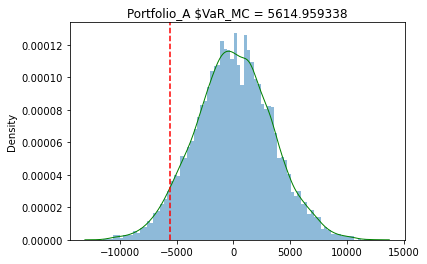

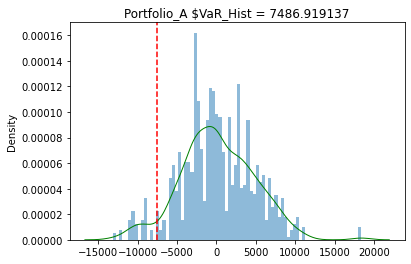

In [26]:
code = 'A'
current_price, delta_var = calculate_delta_var(portfolio, prices, portfolio_code=code)
current_price, mc_var, mc_sim_prices = calculate_MC_var(portfolio, prices, portfolio_code=code)
current_price, hist_var, hist_sim_prices = calculate_historic_var(portfolio, prices, portfolio_code=code)
print("For porfolio_{}".format(code))
print("The current value is: {:.2f}".format(current_price))
print("VaR (Delta Normal) is: {:.2f}".format(delta_var))
print("VaR (Monte Carlo) is: {:.2f}".format(mc_var))
print("VaR (Historic) is: {:.2f}\n".format(hist_var))
plot_histogram_with_var(mc_sim_prices, mc_var, "Portfolio_{} $VaR_MC".format(code))
plot_histogram_with_var(hist_sim_prices, hist_var, "Portfolio_{} $VaR_Hist".format(code))

For porfolio_B
The current value is: 294385.59
VaR (Delta Normal) is: 4494.60
VaR (Monte Carlo) is: 4475.64
VaR (Historic) is: 7273.77



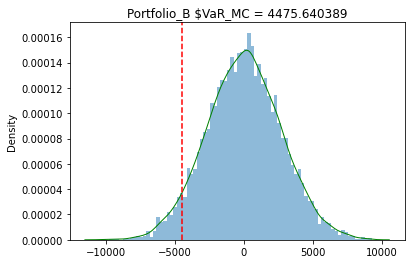

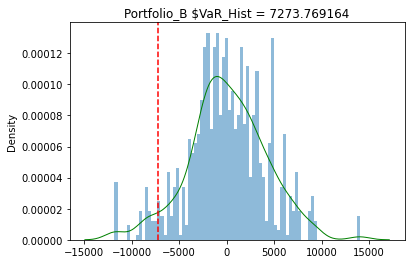

In [27]:
code = 'B'
current_price, delta_var = calculate_delta_var(portfolio, prices, portfolio_code=code)
current_price, mc_var, mc_sim_prices = calculate_MC_var(portfolio, prices, portfolio_code=code)
current_price, hist_var, hist_sim_prices = calculate_historic_var(portfolio, prices, portfolio_code=code)
print("For porfolio_{}".format(code))
print("The current value is: {:.2f}".format(current_price))
print("VaR (Delta Normal) is: {:.2f}".format(delta_var))
print("VaR (Monte Carlo) is: {:.2f}".format(mc_var))
print("VaR (Historic) is: {:.2f}\n".format(hist_var))
plot_histogram_with_var(mc_sim_prices, mc_var, "Portfolio_{} $VaR_MC".format(code))
plot_histogram_with_var(hist_sim_prices, hist_var, "Portfolio_{} $VaR_Hist".format(code))

For porfolio_C
The current value is: 270042.83
VaR (Delta Normal) is: 3786.59
VaR (Monte Carlo) is: 3732.25
VaR (Historic) is: 5310.07



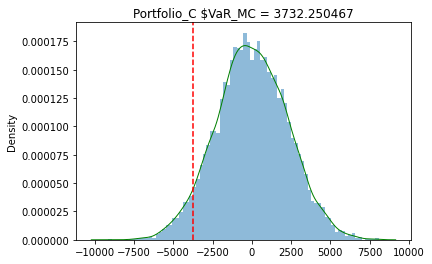

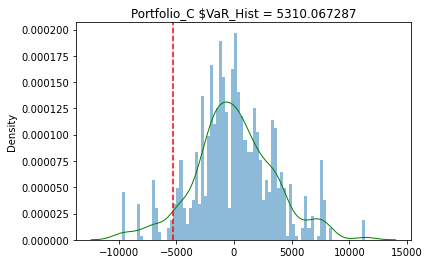

In [28]:
code = 'C'
current_price, delta_var = calculate_delta_var(portfolio, prices, portfolio_code=code)
current_price, mc_var, mc_sim_prices = calculate_MC_var(portfolio, prices, portfolio_code=code)
current_price, hist_var, hist_sim_prices = calculate_historic_var(portfolio, prices, portfolio_code=code)
print("For porfolio_{}".format(code))
print("The current value is: {:.2f}".format(current_price))
print("VaR (Delta Normal) is: {:.2f}".format(delta_var))
print("VaR (Monte Carlo) is: {:.2f}".format(mc_var))
print("VaR (Historic) is: {:.2f}\n".format(hist_var))
plot_histogram_with_var(mc_sim_prices, mc_var, "Portfolio_{} $VaR_MC".format(code))
plot_histogram_with_var(hist_sim_prices, hist_var, "Portfolio_{} $VaR_Hist".format(code))

For porfolio_All
The current value is: 864378.48
VaR (Delta Normal) is: 13577.08
VaR (Monte Carlo) is: 13311.81
VaR (Historic) is: 17832.39



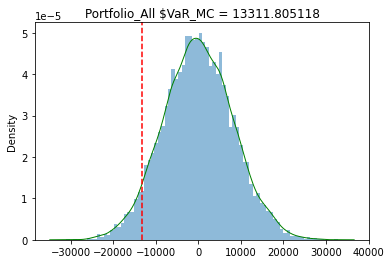

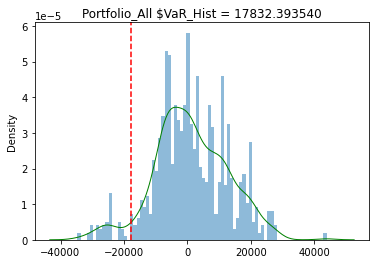

In [29]:
code = 'All'
current_price, delta_var = calculate_delta_var(portfolio, prices, portfolio_code=code)
current_price, mc_var, mc_sim_prices = calculate_MC_var(portfolio, prices, portfolio_code=code)
current_price, hist_var, hist_sim_prices = calculate_historic_var(portfolio, prices, portfolio_code=code)
print("For porfolio_{}".format(code))
print("The current value is: {:.2f}".format(current_price))
print("VaR (Delta Normal) is: {:.2f}".format(delta_var))
print("VaR (Monte Carlo) is: {:.2f}".format(mc_var))
print("VaR (Historic) is: {:.2f}\n".format(hist_var))
plot_histogram_with_var(mc_sim_prices, mc_var, "Portfolio_{} $VaR_MC".format(code))
plot_histogram_with_var(hist_sim_prices, hist_var, "Portfolio_{} $VaR_Hist".format(code))

#### Explain the difference

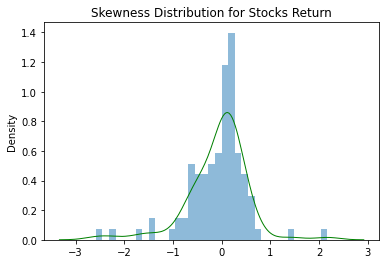

Number of values between -0.1 and 0.1: 20


In [30]:
skewness = returns_all.drop('Date', axis=1).skew()

plt.hist(skewness, bins=35, density=True, alpha=0.5)
sns.kdeplot(skewness, color='g', linewidth=1)
plt.title("Skewness Distribution for Stocks Return")
plt.savefig("Skewness Distribution for Stocks Return", dpi =300)
plt.show()

count = ((skewness >= -0.1) & (skewness <= 0.1)).sum()
print(f"Number of values between -0.1 and 0.1: {count}")

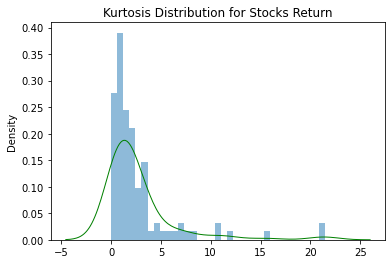

Number of values between -0.1 and 0.1: 4


In [31]:
kurtosis = returns_all.drop('Date', axis=1).kurtosis()

plt.hist(kurtosis, bins=35, density=True, alpha=0.5)
sns.kdeplot(kurtosis, color='g', linewidth=1)
plt.title("Kurtosis Distribution for Stocks Return")
plt.savefig("Kurtosis Distribution for Stocks Return", dpi =300)
plt.show()

count = ((kurtosis >= -0.1) & (kurtosis <= 0.1)).sum()
print(f"Number of values between -0.1 and 0.1: {count}")